<a href="https://colab.research.google.com/github/Anshuman-37/Summer_Dissertation/blob/main/Registered_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### FSL Installation and Kaggle Prerequisties

In [1]:
# ## On Average Takes around 16 minutes 
import os
!sudo apt -qq install file
!wget https://fsl.fmrib.ox.ac.uk/fsldownloads/fslinstaller.py
!python2 fslinstaller.py

fslpath = "/usr/local/fsl"
os.environ["FSLDIR"] = fslpath
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, 'bin')
!. ${FSLDIR}/etc/fslconf/fsl.sh

!flirt -version 

Checking FSL package
[OK] File downloaded
Installing FSL software version 6.0.5.2...
-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-[OK] FSL software installed.
\|Performing post install tasks
/Stage 1
By installing this python distribution you agree to the license terms in
/usr/local/fsl/fslpython/LICENSE.txt
10

In [ ]:

# !pip install kaggle --upgrade
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !mkdir content/data
# !kaggle datasets download -d lyfeisgood/something-bigger
# !unzip /content/something-bigger.zip -d data_new
!pip install regtricks
!pip install torchsummary

#### Header Files

In [ ]:
### Common Libraries
import os
import re
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

### Misc. 
import regtricks as rt

### Torch Files 
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from torchsummary import summary

## Import my .py file ....... 
import Data_Loader as dl
import Models as model
import Prediction as pd


#### 2D convolution

##### Data Loading

In [ ]:
# Take around 10 minutes
## Defining the path of the data 
x,y = dl.data_loader_2D('/content/data_new','/content/data_new',55,device)

## Printing the shape of specifid data
print('\nShape of MRI images - >');     dl.print_data_shape(x); 
print('\nShape of ASL images - >');     dl.print_data_shape(y);

## Printing the Stats of the data
print('\nStats for MRI data(X) - >');   dl.tensor_stats(x); 
print('\nStats for ASL data(X) - >');   dl.tensor_stats(y);

## Printing the Dimension of X and Y  
## Dimension refer -> Number x Channel xLength x Breadth
print('\nDimensions of X(MRI Data) ->',end=' '); dl.print_data_dimension(x)
print('\nDimensions of Y(ASL Data) ->',end=' '); dl.print_data_dimension(y)

train_x , train_y , test_x , test_y = dl.data_split(x,y,0.2)

print('\nDimensions of Train Test Data (MRI) ->',end=' ');      dl.print_data_dimension(train_x) ; dl.print_data_dimension(test_x);
print('\nDimensions of Train Test Data (ASL Data) ->',end=' '); dl.print_data_dimension(train_y) ; dl.print_data_dimension(test_y);

##### Model Training

In [14]:
## Training the model
train_loss, test_loss, predictions = model.train_conv_2D(1,4,train_x,train_y,test_x,test_y,1)
# print('Train Loss',train_loss); 
print('Test Loss ',test_loss); print('Predictions shape', predictions.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 91, 109]              40
       BatchNorm2d-2           [-1, 4, 91, 109]               8
              ReLU-3           [-1, 4, 91, 109]               0
         MaxPool2d-4           [-1, 4, 91, 109]               0
            Conv2d-5           [-1, 8, 91, 109]             296
       BatchNorm2d-6           [-1, 8, 91, 109]              16
              ReLU-7           [-1, 8, 91, 109]               0
         MaxPool2d-8           [-1, 8, 91, 109]               0
            Conv2d-9          [-1, 16, 91, 109]           1,168
      BatchNorm2d-10          [-1, 16, 91, 109]              32
             ReLU-11          [-1, 16, 91, 109]               0
        MaxPool2d-12          [-1, 16, 91, 109]               0
           Conv2d-13           [-1, 8, 91, 109]           1,160
      BatchNorm2d-14           [-1, 8, 

100%|██████████| 2/2 [00:00<00:00, 28.87it/s]

Loss  0.3075537 Memory Occupied by the model 49.5146484375
Test Loss  tensor(0.2899, device='cuda:0', grad_fn=<MseLossBackward0>)
Predictions shape torch.Size([4, 1, 91, 109])


##### Results and Plots

(1, 91, 109)
<class 'numpy.ndarray'>
(4, 1, 91, 109)
<class 'numpy.ndarray'>


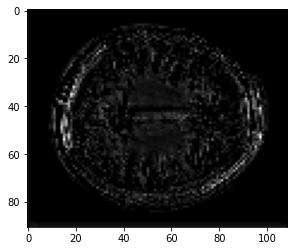

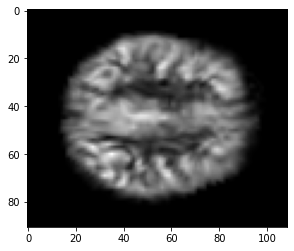

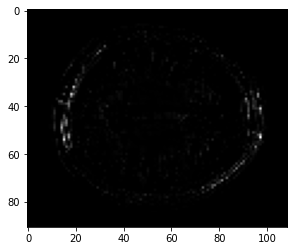

In [11]:


pd.predictions_2D(test_y,predictions,3)
pd.plot_residuals_2D(test_y,predictions,3)



## Average 2D CNN perfusion values

In [15]:
def mse(y_t , y_p):
    '''Calcualtes the mean square error'''
    loss = torch.sum(torch.square(torch.flatten(y_t) - torch.flatten(y_p)))/len(torch.flatten(y_t))
    return loss
## 91 * 109
x = torch.zeros(9919)
for i in train_y:
    # Adding up all the value 
    x = x + torch.flatten(i)
x = x/23

def return_template_loss(template,data):
    '''Returns the loss from the person template'''
    loss = []
    for i in data:
        loss.append(mse(template,i))
    return loss
    
torch.reshape(x, (91, 109))
loss = return_template_loss(x.to(device),train_y.to(device))
s = 0
for i in loss:
    s = i+s 
print('Test loss :',s/len(loss))
x = torch.reshape(x, (1,91, 109))
print(x.shape)

Test loss : tensor(0.0065, device='cuda:0')
torch.Size([1, 91, 109])


#### MISC

In [16]:
print((torch.cuda.memory_allocated())/(1024*1024));
!nvidia-smi

47.955078125
Fri Aug 19 17:53:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    38W / 250W |   1051MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                           

In [17]:
torch.cuda.empty_cache()

#### 3D convolution

##### Data Loading

In [18]:
# Takes approximately 10 minutes 
x,y = dl.data_loader_3D('/content/data_new','/content/data_new',device)

## Printing the shape of specifid data
print('\nShape of MRI images - >');     dl.print_data_shape(x); 
print('\nShape of ASL images - >');     dl.print_data_shape(y);

## Printing the Stats of the data
print('\nStats for MRI data(X) - >');   dl.tensor_stats(x); 
print('\nStats for ASL data(X) - >');   dl.tensor_stats(y);

## Printing the Dimension of X and Y  
## Dimension refer -> Number x Length x Breadth x Height x Channel
print('\nDimensions of X(MRI Data) ->',end=' '); dl.print_data_dimension(x)
print('\nDimensions of Y(ASL Data) ->',end=' '); dl.print_data_dimension(y)

train_x , train_y , test_x , test_y = dl.data_split(x,y,0.2)

print('\nDimensions of Train Test Data (MRI) ->',end=' ');      dl.print_data_dimension(train_x) ; dl.print_data_dimension(test_x);
print('\nDimensions of Train Test Data (ASL Data) ->',end=' '); dl.print_data_dimension(train_y) ; dl.print_data_dimension(test_y);


Shape of MRI images - >
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])

Shape of ASL images - >
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109

##### Model Training


In [19]:
train_loss,test_loss, predictions = mdl.train_conv_3D(1,4,train_x,train_y,test_x,test_y,1)
print('Test Loss ',test_loss); print('Predictions shape', predictions.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 4, 91, 109, 92]              76
       BatchNorm3d-2       [-1, 4, 91, 109, 92]               8
              ReLU-3       [-1, 4, 91, 109, 92]               0
         MaxPool3d-4       [-1, 4, 91, 109, 92]               0
            Conv3d-5       [-1, 8, 91, 109, 93]             584
       BatchNorm3d-6       [-1, 8, 91, 109, 93]              16
              ReLU-7       [-1, 8, 91, 109, 93]               0
         MaxPool3d-8       [-1, 8, 91, 109, 93]               0
            Conv3d-9      [-1, 16, 91, 109, 94]           2,320
      BatchNorm3d-10      [-1, 16, 91, 109, 94]              32
             ReLU-11      [-1, 16, 91, 109, 94]               0
        MaxPool3d-12      [-1, 16, 91, 109, 94]               0
           Conv3d-13       [-1, 8, 91, 109, 95]           2,312
      BatchNorm3d-14       [-1, 8, 91, 

 50%|█████     | 1/2 [00:10<00:10, 10.40s/it]

Loss  0.7012521 Memory Occupied by the model 179.05712890625


100%|██████████| 2/2 [00:13<00:00,  6.57s/it]

Test Loss  tensor(0.6739, device='cuda:0', grad_fn=<MseLossBackward0>)
Predictions shape torch.Size([4, 1, 91, 109, 91])


##### Results and Video

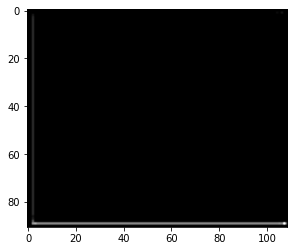

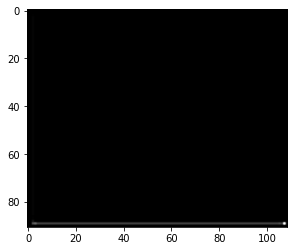

In [23]:
pd.predictions_3D(train_y,predictions,0)
pd.plot_residuals_3D(test_y,predictions,1)

from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/Result.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)



In [24]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/Residual.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
del test_loss, predictions


## Average 3D CNN perfusion image

In [25]:
def mse(y_t , y_p):
    ## To calculate the mean square error
    loss = torch.sum(torch.square(torch.flatten(y_t) - torch.flatten(y_p)))/len(torch.flatten(y_t))
    return loss


def return_template_loss(template,data):
    '''Returns the loss from the person template'''
    loss = []
    for i in data:
        loss.append(mse(template,i))
    return loss

x = torch.zeros(902629)
for i in train_y:
    x = x + torch.flatten(i)
x = x/19
torch.reshape(x, (91, 109,91))
loss = return_template_loss(x.to(device),test_y.to(device))
s = 0
for i in loss:
    s = i+s 
print(s/len(loss))

tensor(0.0033, device='cuda:0')
